# Certification Challenge

#### Dependencies and API Keys

In [1]:
import os 
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API key:")
os.environ["TAVILY_API_KEY"] = getpass.getpass("Tavily API key:")
os.environ["YOUTUBE_API_KEY"] = getpass.getpass("Youtube API key:")
os.environ["COHERE_API_KEY"] = getpass.getpass("Cohere API key:")

In [29]:
# Langsmith
from uuid import uuid4

os.environ["LANGSMITH_TRACING_V2"] ="true"
os.environ["LANGCHAIN_PROJECT"] = F"AIE8 Certification Challenge - {uuid4().hex[0:8]}"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("Langsmith API key: ")

In [271]:
# !pip install langchain-core

In [272]:
# !pip install youtube-transcript-api

In [ ]:
# !pip install langchain-cohere


  Attempting uninstall: httpx-sse

    Found existing installation: httpx-sse 0.4.1

    Uninstalling httpx-sse-0.4.1:

      Successfully uninstalled httpx-sse-0.4.1

   ------------- -------------------------- 2/6 [httpx-sse]
   -------------------- ------------------- 3/6 [fastavro]
   -------------------- ------------------- 3/6 [fastavro]
   -------------------- ------------------- 3/6 [fastavro]
   -------------------- ------------------- 3/6 [fastavro]
   -------------------- ------------------- 3/6 [fastavro]
   -------------------- ------------------- 3/6 [fastavro]
   -------------------- ------------------- 3/6 [fastavro]
   -------------------------- ------------- 4/6 [cohere]
   -------------------------- ------------- 4/6 [cohere]
   -------------------------- ------------- 4/6 [cohere]
   -------------------------- ------------- 4/6 [cohere]
   -------------------------- ------------- 4/6 [cohere]
   -------------------------- ------------- 4/6 [cohere]
   -------------


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [449]:
# !pip install rank_bm25


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [54]:
# !pip install langchain-tavily


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: C:\Users\Inés\AppData\Local\Programs\Python\Python313\python.exe -m pip install --upgrade pip


#### Initial Data Collection

#### Utility functions

In [2]:
import os
import requests

In [3]:
video_id= 'iqNzfK4_meQ'

In [4]:
# Get comments
def get_youtube_comments(video_id: str, max_comments: int = 50):
    url = "https://www.googleapis.com/youtube/v3/commentThreads"
    params = {
        'part': 'snippet',
        'videoId': video_id,
        'maxResults': max_comments,
        'key': os.environ['YOUTUBE_API_KEY']
    }
    response = requests.get(url, params=params)
    return response.json()

In [5]:
# Get video details
def get_video_details(video_id: str):
    """Get video metadata including title, description, channel info, etc."""
    url = "https://www.googleapis.com/youtube/v3/videos"
    params = {
        'part': 'snippet,statistics,contentDetails',
        'id': video_id,
        'key': os.environ['YOUTUBE_API_KEY']
    }
    response = requests.get(url, params=params)
    return response.json()


In [6]:
# Get video transcrips
from youtube_transcript_api import YouTubeTranscriptApi

def get_video_transcript(video_id: str):
    """Get video transcript using YouTube Transcript API."""
    try:
        api = YouTubeTranscriptApi()
        full_transcript = api.fetch(video_id)
        transcript_text = " ".join(
        full_transcript.snippets[i].text for i in range(len(full_transcript.snippets))
            )
        print(f"DEBUG: Transcript fetched for {video_id}, length={len(transcript_text)}")
        return {"transcript": transcript_text}
    
    except Exception as exc:  # noqa: BLE001
        print(f"WARNING: Transcript fetch failed for {video_id}: {exc}")
        return {
                "transcript": "",
                "error": f"Unable to fetch transcript: {exc}",
            }


#### Create the text document

In [7]:

# Create unified document tool from video
from langchain_core.documents import Document

def create_unified_video_document(video_id: str, max_comments: int = 50):
    """
    Create a unified document containing video details, transcript, and comments.
    This gives the chatbot complete context about the video.
    """
    # Get all data
    video_details = get_video_details(video_id)
    comments_data = get_youtube_comments(video_id, max_comments)
    transcript_data = get_video_transcript(video_id)
    
    # Extract key information
    video_info = video_details['items'][0] if video_details.get('items') else {}
    snippet = video_info.get('snippet', {})
    statistics = video_info.get('statistics', {})
    
    # Format comments
    formatted_comments = []
    if 'items' in comments_data:
        for item in comments_data['items']:
            comment = item['snippet']['topLevelComment']['snippet']
            formatted_comments.append({
                'text': comment.get('textDisplay', ''),
                'author': comment.get('authorDisplayName', ''),
                'likes': comment.get('likeCount', 0),
                'published': comment.get('publishedAt', '')
            })
    
    # Create unified content
    unified_content = f"""
# VIDEO ANALYSIS CONTEXT

## Video Information
**Title:** {snippet.get('title', 'N/A')}
**Channel:** {snippet.get('channelTitle', 'N/A')}
**Published:** {snippet.get('publishedAt', 'N/A')}
**Views:** {statistics.get('viewCount', 'N/A')}
**Likes:** {statistics.get('likeCount', 'N/A')}
**Comments Count:** {statistics.get('commentCount', 'N/A')}

## Video Description
{snippet.get('description', 'No description available')}

## Video Transcript
{transcript_data.get('transcript', 'No transcription available')}

## Comments Analysis
**Total Comments Analyzed:** {len(formatted_comments)}

### Comment Details:
"""
    
    # Add individual comments
    for i, comment in enumerate(formatted_comments, 1):
        unified_content += f"""
**Comment {i}:**
- Author: {comment['author']}
- Likes: {comment['likes']}
- Published: {comment['published']}
- Text: {comment['text']}
---
"""
    
    # Create the document
    unified_document = Document(
        page_content=unified_content,
        metadata={
            "type": "unified_video_analysis",
            "video_id": video_id,
            "title": snippet.get('title', ''),
            "channel": snippet.get('channelTitle', ''),
            "comment_count": len(formatted_comments),
            "has_transcript": bool(transcript_data.get('transcript')),
            "views": statistics.get('viewCount', 0),
            "likes": statistics.get('likeCount', 0),
            "published": snippet.get('publishedAt', ''),
            "source": "youtube_unified"
        }
    )
    
    return unified_document, {
        'video_details': video_details,
        'comments': comments_data,
        'transcript': transcript_data,
        'formatted_comments': formatted_comments
    }

#### Organize document for vector database, context + comments, with metadata

>Note To illustrate chunking we will used it, in case there is a transcript and it is long.

In [8]:
#1. build structured Document objects

from langchain_core.documents import Document

unified_document, raw_blobs = create_unified_video_document(video_id)
formatted_comments = raw_blobs["formatted_comments"]

# video-level context document
context_doc = Document(
    page_content=unified_document.page_content,
    metadata={
        "type": "video_context",
        "video_id": unified_document.metadata["video_id"],
        "title": unified_document.metadata.get("title", ""),
        "channel": unified_document.metadata.get("channel", ""),
        "source": "youtube_unified",
    },
)

# one document per comment with rich payload
comment_docs = [
    Document(
        page_content=comment["text"],
        metadata={
            "type": "comment",
            "comment_index": idx + 1,
            "author": comment["author"],
            "likes": comment["likes"],
            "published": comment["published"],
            "video_id": unified_document.metadata["video_id"],
            "title": unified_document.metadata.get("title", ""),
        },
    )
    for idx, comment in enumerate(formatted_comments)
]

DEBUG: Transcript fetched for iqNzfK4_meQ, length=5854


In [9]:
unified_document

Document(metadata={'type': 'unified_video_analysis', 'video_id': 'iqNzfK4_meQ', 'title': 'Using OpenAI Codex CLI with GPT-5-Codex', 'channel': 'OpenAI', 'comment_count': 50, 'has_transcript': True, 'views': '134177', 'likes': '3042', 'published': '2025-10-14T18:19:27Z', 'source': 'youtube_unified'}, page_content='\n# VIDEO ANALYSIS CONTEXT\n\n## Video Information\n**Title:** Using OpenAI Codex CLI with GPT-5-Codex\n**Channel:** OpenAI\n**Published:** 2025-10-14T18:19:27Z\n**Views:** 134177\n**Likes:** 3042\n**Comments Count:** 265\n\n## Video Description\nLearn how to use the Codex CLI + GPT-5-Codex in just 5 minutes.\n\n\nIn this tutorial, Eason Goodale and Romain Huet show you how to build a multiplayer game with Codex — without writing a single line of code! \n\nTimestamps:\n\n00:00 Intro\n00:50 Planning the multiplayer implementation\n1:38 Using CLI commands\n2:55 Implementing the plan\n3:31 Deploy the game\n4:20 Playing the game\n\n\nTo learn more and get started:\n\nCodex: openai

#### Simple LangGraph RAG

#### Retrieval

In [10]:
# R (Naive Retrieval)

# 2. Chunk only the long context (long transcripts)

from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=750,
    chunk_overlap=150,
)

context_chunks = text_splitter.split_documents([context_doc])
docs_for_store = context_chunks + comment_docs # no chunking comments


In [63]:
# Embeddings
from langchain_openai.embeddings import OpenAIEmbeddings

embedding = OpenAIEmbeddings(model="text-embedding-3-small") # Sufficient for comments

In [12]:
# QDrant vectorstore

from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

client = QdrantClient(":memory:")

client.create_collection(
    collection_name="video_sentiment_data",
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE),
)

vector_store = QdrantVectorStore(
    client=client,
    collection_name="video_sentiment_data",
    embedding=embedding,
)

# Add the chunked documents to the vector store
_ = vector_store.add_documents(docs_for_store)

print(f"Added {len(docs_for_store)} document chunks to the vector store")
print(f"Vector store collection: video_sentiment_data")
print(f"Embedding model: text-embedding-3-small (1536 dimensions)")

Added 88 document chunks to the vector store
Vector store collection: video_sentiment_data
Embedding model: text-embedding-3-small (1536 dimensions)


In [13]:
qdrant_retriever = vector_store.as_retriever(
    search_kwargs = {"k":6}
)

#### Augmented

In [14]:
from langchain_core.prompts import ChatPromptTemplate

HUMAN_TEMPLATE = """
#CONTEXT:
{context}

QUERY:
{query}

"Use the provided context, which consists of YouTube comments, "
"to answer the user query. Only use the provided context to answer the query." 
"When forming your response, take into account the topics discussed, the users who made the comments, " 
"and the sentiment expressed in the comments to increase factual correctness and answer relevancy. " 
"The chatbot is intended to answer questions about users' opinions of the video. " 
"If you do not know the answer, or it is not contained in the provided context, respond with "I don't know.""
"""

chat_prompt = ChatPromptTemplate.from_messages([
    ("human", HUMAN_TEMPLATE)
])


#### Generation

In [62]:
from langchain_openai import ChatOpenAI

generator_llm = ChatOpenAI(model = "gpt-4.1-nano")

RAG - Retrieval Augmented Generation


In [16]:
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict
from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser

class State(TypedDict):
    question: str
    context: List[Document]
    response: str

def retrieve(state: State):
    retrieved_docs = qdrant_retriever.invoke(state['question'])
    return {"context": retrieved_docs}
    

def generate(state: State):
    generator_chain = chat_prompt | generator_llm | StrOutputParser()
    response = generator_chain.invoke({"query": state['question'], "context": state["context"]})
    return {'response': response}

rag_graph = StateGraph(State).add_sequence([retrieve, generate])
rag_graph.add_edge(START, "retrieve")
compiled_rag_graph = rag_graph.compile()



In [17]:
compiled_rag_graph.invoke({'question':'Which are most comments saying'})

{'question': 'Which are most comments saying',
 'context': [Document(metadata={'type': 'comment', 'comment_index': 27, 'author': '@dandragomir6413', 'likes': 0, 'published': '2025-10-16T00:23:30Z', 'video_id': 'iqNzfK4_meQ', 'title': 'Using OpenAI Codex CLI with GPT-5-Codex', '_id': '3b479fbeef424023b61a56c8fd770b9d', '_collection_name': 'video_sentiment_data'}, page_content='are all comments here written by bots? thats what it seems like'),
  Document(metadata={'type': 'video_context', 'video_id': 'iqNzfK4_meQ', 'title': 'Using OpenAI Codex CLI with GPT-5-Codex', 'channel': 'OpenAI', 'source': 'youtube_unified', '_id': '310a06c15dbc45a686902704788e5d21', '_collection_name': 'video_sentiment_data'}, page_content='**Comment 25:**\n- Author: @jamaalcodes\n- Likes: 0\n- Published: 2025-10-16T01:15:03Z\n- Text: I need this long haired guys github lol\n---\n\n**Comment 26:**\n- Author: @remlik\n- Likes: 0\n- Published: 2025-10-16T00:34:17Z\n- Text: what kind of psycho uses terminal in light

#### Imports

In [18]:
from typing import Any, Callable, List, Optional, TypedDict, Union

from langchain.agents import AgentExecutor, create_openai_functions_agent
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.runnables import Runnable
from langchain_core.tools import BaseTool
from langchain_openai import ChatOpenAI


from langgraph.graph import END, StateGraph


##### Helper functions to create node, agents, supervisor

In [19]:
# Agent node helper
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {
        "messages": [HumanMessage(content=result["output"], name=name)],
        "documents": result.get("documents", [])
        
        }

In [20]:
# Custom node for CommentFinder as it needs to return the documents
def agent_node_with_docs(state, agent, name):
    result = agent.invoke(state)
    output = result["output"]
    
    # Try to extract documents if this is CommentFinder
    documents = []
    if name == "CommentFinder":
        # Parse the output to extract documents if they're returned
        # The tool returns a dict, but agent wraps it as string
        # We need to access the raw tool result
        try:
            # Get the intermediate steps from agent execution
            if "intermediate_steps" in result:
                for action, observation in result["intermediate_steps"]:
                    if isinstance(observation, dict) and "documents" in observation:
                        documents = observation["documents"]
        except:
            documents = []
    
    return {
        "messages": [HumanMessage(content=output, name=name)],
        "documents": documents if documents else state.get("documents", [])
    }

In [21]:
# Agent creation helper function

def create_agent(
    llm: ChatOpenAI,
    tools: list,
    system_prompt: str,
) -> str:
    """Create a function-calling agent and add it to the graph."""
    system_prompt += ("\nWork autonomously according to your specialty, using the tools available to you."
    " Do not ask for clarification."
    " Your other team members (and other teams) will collaborate with you with their own specialties."
    " You are chosen for a reason!")
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_functions_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools, return_intermediate_steps=True)
    return executor


In [22]:
# Supervisor Helper function
def create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:
    """An LLM-based router."""
    options = ["FINISH"] + members
    function_def = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ],
                },
            },
            "required": ["next"],
        },
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    return (
         prompt
         | llm.bind_functions(functions=[function_def], function_call="route")
         | JsonOutputFunctionsParser()
             )

#### Research Team - A LangGraph for Researching public sentiment

In [50]:
# We are going to enhance the search with video specific information
from langchain_core.output_parsers import StrOutputParser

summarization_llm = ChatOpenAI(model='gpt-4o-mini')

SUMMARIZATION_TEMPLATE = (
    "You are an editorial analyst turning raw YouTube transcripts into concise research briefings.\n"
    "Video title: {title}\n"
    "Channel: {channel}\n"
    "Transcript excerpt:\n{transcript}\n\n"
    "Write a tight summary under 110 words that:"
    "\n- Captures the main topics and arguments"
    "\n- Names key people, brands, or entities mentioned"
    "\n- Notes tone shifts or controversies if present"
    "\n- Highlights any actionable insights for a researcher"
    "\nUse short sentences separated by semicolons. If the transcript excerpt is empty, respond with 'No transcript available.'"
)
chat_summarization_prompt = ChatPromptTemplate.from_messages([("human", SUMMARIZATION_TEMPLATE)])

summarization_chain = chat_summarization_prompt | summarization_llm | StrOutputParser()

In [23]:
# Set up global variables for video_specific_search tool
# These will be accessible via closure in the tool function

title = unified_document.metadata.get("title", "")
channel = unified_document.metadata.get("channel", "")
transcript = unified_document.page_content  # Full unified document content
# formatted_comments is already defined earlier from raw_blobs["formatted_comments"]

print(f"Video context loaded:")
print(f"  Title: {title}")
print(f"  Channel: {channel}")
print(f"  Comments available: {len(formatted_comments)}")


Video context loaded:
  Title: Using OpenAI Codex CLI with GPT-5-Codex
  Channel: OpenAI
  Comments available: 50


In [25]:
# Initialize Tavily search tool
from langchain_tavily import TavilySearch

tavily = TavilySearch(max_results=5)
print("Tavily search tool initialized")


Tavily search tool initialized


In [26]:
from langchain_core.tools import tool
from typing import Annotated, List
@tool
def video_specific_search(
    query: Annotated[str, "Search query - can be about the current video's topic OR to find other related videos"]
) -> str:
    """Search for external information using web search (Tavily).
    
    Use this for:
    - Finding other videos from the same creator/channel
    - Searching for information about topics mentioned in the video
    - Looking up external context related to the video's content
    - General web searches enhanced with video context
    
    The search automatically includes the current video's title and channel for context.
    """
    
    search_context: List[str] = []
    if title:
        search_context.append(f'"{title}"')
    if channel:
        search_context.append(f"channel:{channel}")
    if transcript:
        summary = summarization_chain.invoke(
            {
                "title": title,
                "channel": channel,
                "transcript": transcript,
            }
        )
        search_context.append(f"transcript summary: {summary}")

    enhanced_query = f"{query} {' '.join(search_context)}" if search_context else query

    results = tavily.invoke(enhanced_query)

    output_lines = [f"## Search Results for: {title or 'Unknown Video'}"]
    output_lines.append(f"**Channel:** {channel or 'Unknown Channel'}")
    output_lines.append(f"**Enhanced Query:** {enhanced_query}\n")

    # Handle both list of dicts and list of strings from Tavily
    for index, result in enumerate(results[:4], start=1):
        output_lines.append(f"### Result {index}")
        if isinstance(result, dict):
            output_lines.append(f"**URL:** {result.get('url', 'N/A')}")
            output_lines.append(f"**Title:** {result.get('title', 'N/A')}")
            output_lines.append(
                f"**Summary:** {result.get('content', 'No content available')}"
            )
        elif isinstance(result, str):
            # If result is a string, just display it as content
            output_lines.append(f"**Content:** {result}")
        else:
            output_lines.append(f"**Result:** {str(result)}")

    return "\n".join(output_lines)

In [27]:
# Creating a custom tool for retrieval that also stores documents globally
from typing import Annotated
from langchain_core.tools import tool

# Global variable to store documents (workaround for tool serialization)
_retrieved_documents = []

@tool
def retrieve_information(
    query: Annotated[str, "query to ask the retrieve information tool"]
):
 """Use Retrieval Augmented Generation to retrieve information related to user query"""
 global _retrieved_documents
 result = compiled_rag_graph.invoke({"question": query})

 _retrieved_documents = result['context']
 # Also return dict (though tool will serialize it to string)
 return {
    "response" : result['response'],
    "documents" : result['context']
 }   

In [28]:
# Reserah team state
import functools
import operator

from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI
import functools

class ResearchTeamState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    documents: List[Document]  
    team_members: List[str]
    next: str


In [29]:
# llm for researching
research_llm = ChatOpenAI(model="gpt-4o-mini")

In [30]:
# Research Team: Video-Aware Search Agent + node

search_agent = create_agent(
    research_llm, 
    [video_specific_search], 
    """You are a video-aware research assistant specialized in finding external information 
    related to the current video being analyzed. Your searches are automatically enhanced 
    with video context (title, channel, etc.) to provide more relevant results.
    
    When users ask about:
    - Public opinion: Search for reactions, reviews, and discussions about this specific video
    - Background info: Look for information about the video creator, topic, or related content
    
    Always focus your searches on content that would help understand sentiment and topics 
    in the video comments better."""
)
search_node = functools.partial(agent_node, agent=search_agent, name='VideoSearch')


In [31]:
# Research Team: 

research_agent = create_agent(
research_llm, 
[retrieve_information],  
"You are a research assistant who can retrieve and provide specific comments related to the query."
)
research_node = functools.partial(agent_node_with_docs, agent=research_agent, name= 'CommentFinder')

In [32]:
# Research Supervisor - Updated for Video-Specific Search
research_supervisor_agent = create_team_supervisor(
    research_llm,
    ("You are a supervisor tasked with managing a conversation between the"
    " following workers: VideoSearch, CommentFinder. Given the following user request,"
    " determine the subject to be researched and respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. "
    " "
    "VideoSearch: Use for external information related to the video (public opinions, background info, related content)"
    "CommentFinder: Use for internal video data (comments, transcript, video details)"
    " "
    " You should never ask your team to do anything beyond research. They are not required to write content or posts."
    " You should only pass tasks to workers that are specifically research focused."
    " When finished, respond with FINISH."),
    ["VideoSearch", "CommentFinder"],  # Updated team member names
)

C:\Users\Inés\AppData\Local\Temp\ipykernel_274228\3669758045.py:35: LangChainDeprecationWarning: The method `BaseChatOpenAI.bind_functions` was deprecated in langchain-openai 0.2.1 and will be removed in 1.0.0. Use :meth:`~langchain_openai.chat_models.base.ChatOpenAI.bind_tools` instead.
  | llm.bind_functions(functions=[function_def], function_call="route")


In [33]:
# Research Team Graph Creation

research_graph = StateGraph(ResearchTeamState)

research_graph.add_node("VideoSearch", search_node)  # Updated to VideoSearch
research_graph.add_node("CommentFinder", research_node)
research_graph.add_node("ResearchSupervisor", research_supervisor_agent)

In [34]:
research_graph.add_edge("VideoSearch", "ResearchSupervisor")  # Updated edge
research_graph.add_edge("CommentFinder", "ResearchSupervisor")
research_graph.add_conditional_edges(
    "ResearchSupervisor",
    lambda x: x["next"],
    {"VideoSearch": "VideoSearch", "CommentFinder": "CommentFinder", "FINISH": END},  # Updated routing
)
research_graph.set_entry_point("ResearchSupervisor")

In [35]:
compiled_research_graph = research_graph.compile()

In [ ]:
# compiled_research_graph #run if not timeouterror

In [40]:
# We need a wrapper around compiled_research_graph to preserve the documents

from langchain_core.runnables import RunnablePassthrough

def research_chain_with_docs(state):
    """
    Run research chain and explicitly preserve documents in state.
   
    """
    # Run the research graph
    result = compiled_research_graph.invoke(state)
    
    # Explicitly extract and preserve documents
    # (assuming they're stored somewhere in the result or state)
    return {
        "messages": result["messages"],
        "documents": result.get("documents", state.get("documents", []))
    }



In [42]:
# Broadcast messages down to Research Team LangGraph
from langchain_core.runnables import RunnableLambda

def enter_research_chain(message: str):
    results = {
        "messages": [HumanMessage(content=message)],
        # "documents": [] # Initializing the documents
    }
    return results

# Wrap functions in RunnableLambda to make them pipeable
research_chain = (
    RunnableLambda(enter_research_chain) 
    | RunnableLambda(research_chain_with_docs)
)


In [43]:
for s in research_chain.stream(
    "What can you tell me about the overall video sentiment?", {"recursion_limit": 100}
):
    if "__end__" not in s:
        print(s)
        print("---")

{'messages': [HumanMessage(content='What can you tell me about the overall video sentiment?', additional_kwargs={}, response_metadata={}), HumanMessage(content='The overall sentiment toward the video titled **"Using OpenAI Codex CLI with GPT-5-Codex"** appears to be positive. Comments indicate viewer interest and approval, with specific praise for Adam Driver’s performance from a user who stated, "Adam Driver is great in this video." There are a few critical and humorous remarks about the content of the video and visual aspects, such as discrepancies between narration and visuals or the color scheme, but these are not predominant.\n\nThe video has garnered significant engagement, with **3,042 likes** and **265 comments**, suggesting that the audience finds it interesting and valuable. Overall, the sentiment indicates a favorable reception, reflecting enthusiasm for the content presented.', additional_kwargs={}, response_metadata={}, name='CommentFinder')], 'documents': [Document(metada

#### Sentiment-Topic Analysis team

In [44]:
# Defininf the tools

@tool(description="Sentiment analysis reflection tool for quality decision-making")
def sentiment_think_tool(reflection: str) -> str:
    """Tool for strategic reflection during sentiment analysis workflows.

    Use this tool to pause and reflect on sentiment analysis progress, ensuring high-quality insights.

    When to use:
    - After processing comment batches: What sentiment patterns emerged?
    - Before finalizing analysis: Do I have sufficient data for reliable conclusions?
    - When encountering mixed sentiments: How should I categorize ambiguous cases?
    - Before generating reports: Are my sentiment classifications well-supported?

    Reflection should address:
    1. Sentiment pattern recognition - What dominant sentiments did I identify?
    2. Data quality assessment - Are the comments representative and sufficient?
    3. Classification confidence - How certain am I about sentiment labels?
    4. Analysis completeness - Do I need more data or can I proceed with conclusions?

    Args:
        reflection: Your detailed reflection on sentiment analysis findings, patterns, and next steps

    Returns:
        Confirmation that sentiment analysis reflection was recorded
    """
    return f"Sentiment analysis reflection recorded: {reflection}"


@tool(description="Topic extraction reflection tool for quality categorization")
def topic_think_tool(reflection: str) -> str:
    """Tool for strategic reflection during topic extraction workflows.

    Use this tool to pause and reflect on topic discovery progress, ensuring comprehensive theme identification.

    When to use:
    - After processing content batches: What topics and themes emerged?
    - Before finalizing categorization: Do I have sufficient examples for each topic?
    - When encountering ambiguous content: How should I categorize unclear topics?
    - Before generating topic reports: Are my topic classifications well-supported?

    Reflection should address:
    1. Topic discovery - What distinct themes and subjects did I identify?
    2. Topic coverage - Do I have enough examples for reliable topic classification?
    3. Classification confidence - How certain am I about topic labels and boundaries?
    4. Analysis completeness - Do I need more content or can I proceed with topic conclusions?

    Args:
        reflection: Your detailed reflection on topic extraction findings, themes, and next steps

    Returns:
        Confirmation that topic extraction reflection was recorded
    """
    return f"Topic extraction reflection recorded: {reflection}"


In [45]:
# Defining Team state

import operator

class SentimentState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    documents: List[Document]
    team_members: str
    next: str
    


In [46]:
analysis_llm = ChatOpenAI(model="gpt-4o-mini")

In [47]:
topic_agent = create_agent(
    analysis_llm,
    [topic_think_tool],
    ("You are an expert at topic extraction"),
)

topic_node = functools.partial(agent_node, agent=topic_agent, name='Topic')

sentiment_agent = create_agent(
    analysis_llm,
    [sentiment_think_tool],
    ("You are an expert at sentiment analysis")
)

sentiment_node = functools.partial(agent_node, agent=sentiment_agent, name='Sentiment')


analysis_supervisor_agent = create_team_supervisor(
    analysis_llm,
    ("You are a supervisor tasked with managing a conversation between the"
    " following workers: {team_members}. You should always verify the analysis"
    " contents after any decision is been made. "
    "Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When each team is finished,"
    " you must respond with FINISH."),
    ["Sentiment", "Topic"],
)




In [48]:
sentiment_graph = StateGraph(SentimentState)
sentiment_graph.add_node("Topic", topic_node)
sentiment_graph.add_node("Sentiment", sentiment_node)
sentiment_graph.add_node("AnalysisSupervisor", analysis_supervisor_agent)

sentiment_graph.add_edge("Topic", "AnalysisSupervisor")
sentiment_graph.add_edge("Sentiment", "AnalysisSupervisor")


sentiment_graph.add_conditional_edges(
    "AnalysisSupervisor",
    lambda x: x["next"],
    {
        "Topic": "Topic",
        "Sentiment": "Sentiment",
        "FINISH": END,
    },
)

sentiment_graph.set_entry_point("AnalysisSupervisor")

In [49]:
compiled_sentiment_graph = sentiment_graph.compile()

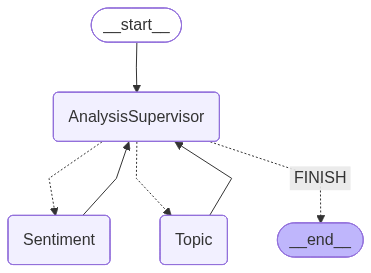

In [250]:
compiled_sentiment_graph

In [50]:
def enter_sentiment_chain(state: dict, members: List[str]):
    """Prepare state for sentiment analysis team"""
    results = {
        "messages": [HumanMessage(content=state["message"])],
        "documents": state.get("documents", []),
        "team_members": ", ".join(members),
    }
    return results

# Use RunnableLambda for proper LCEL composition
analysis_chain = (
    RunnableLambda(functools.partial(enter_sentiment_chain, members=sentiment_graph.nodes))
    | compiled_sentiment_graph
)

In [51]:
#test analysis chain: we provide a sample of documents as it is design to work inside the super_graph

test_documents = docs_for_store[:5]  

# Call analysis_chain with both message and documents
for s in compiled_sentiment_graph.stream(
    {
        "messages": [HumanMessage(content="What are the main sentiment patterns in these comments?")],
        "documents": test_documents,
        "team_members": ", ".join(sentiment_graph.nodes)
    },
    {"recursion_limit": 100},
):
    if "__end__" not in s:
        print(s)
        print("---")

{'AnalysisSupervisor': {'next': 'Sentiment'}}
---
{'Sentiment': {'messages': [HumanMessage(content='Please provide the comments you would like me to analyze for sentiment patterns.', additional_kwargs={}, response_metadata={}, name='Sentiment')], 'documents': [Document(metadata={'type': 'video_context', 'video_id': 'iqNzfK4_meQ', 'title': 'Using OpenAI Codex CLI with GPT-5-Codex', 'channel': 'OpenAI', 'source': 'youtube_unified'}, page_content='# VIDEO ANALYSIS CONTEXT\n\n## Video Information\n**Title:** Using OpenAI Codex CLI with GPT-5-Codex\n**Channel:** OpenAI\n**Published:** 2025-10-14T18:19:27Z\n**Views:** 134177\n**Likes:** 3042\n**Comments Count:** 265\n\n## Video Description\nLearn how to use the Codex CLI + GPT-5-Codex in just 5 minutes.\n\n\nIn this tutorial, Eason Goodale and Romain Huet show you how to build a multiplayer game with Codex — without writing a single line of code! \n\nTimestamps:\n\n00:00 Intro\n00:50 Planning the multiplayer implementation\n1:38 Using CLI co

In [52]:
#### Meta-Supervisor and full graph

from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI

super_llm = ChatOpenAI(model="gpt-4o-mini")

super_supervisor_agent = create_team_supervisor(
    super_llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following teams: {team_members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When all workers are finished,"
    " you must respond with FINISH.",
    ["Research team", "Analysis team"],
)

In [53]:
class State(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    documents: List[Document]  
    next: str

def get_last_message(state: State) -> str:
    return state["messages"][-1].content


def join_graph(response: dict):
    result = {"messages": [response["messages"][-1]]}
    if "documents" in response and response["documents"]:
        result["documents"] = response["documents"]
    return result

def get_messages_and_documents(state: State):
    # Extract the last message content and documents
    message = state["messages"][-1].content
    documents = state.get("documents", [])
    # Call analysis_chain and join_graph in one function
    result = analysis_chain.invoke({"message": message, "documents": documents})
    return join_graph(result)
    

In [54]:
super_graph = StateGraph(State)

super_graph.add_node("Research team", get_last_message | research_chain | join_graph)
super_graph.add_node("Analysis team", get_messages_and_documents)
super_graph.add_node("SuperSupervisor", super_supervisor_agent)

In [55]:
super_graph.add_edge("Research team", "SuperSupervisor")
super_graph.add_edge("Analysis team", "SuperSupervisor")
super_graph.add_conditional_edges(
    "SuperSupervisor",
    lambda x: x["next"],
    {
        "Analysis team": "Analysis team",
        "Research team": "Research team",
        "FINISH": END,
    },
)
super_graph.set_entry_point("SuperSupervisor")

In [57]:
compiled_super_graph = super_graph.compile()
# compiled_super_graph

In [58]:
# Use the graph

for s in compiled_super_graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Tell me the overall sentiment and topics that arise in the comments of this video"
            )
        ],
        "documents": []
    },
    {"recursion_limit": 30},
):
    if "__end__" not in s:
        print(s)
        print("---")

{'SuperSupervisor': {'next': 'Research team'}}
---
{'Research team': {'messages': [HumanMessage(content='The comments on the video titled "Using OpenAI Codex CLI with GPT-5-Codex" exhibit a generally neutral to mildly positive sentiment, with many users showing curiosity, some skepticism, and a bit of humor. \n\n**Key Topics and Sentiments:**\n\n1. **Technical Curiosity**: \n   - Users are interested in understanding the technical distinctions in the content; e.g., one comment asks why what\'s said in the video differs from what\'s shown.\n   - A user questions the nature of the video itself, wondering whether it’s entirely AI-generated.\n\n2. **Appreciation for Content**: \n   - Comments express positive sentiments about elements within the video, with appreciation for figures like Adam Driver contributing positively, e.g., discussing his performance.\n\n3. **Visual Presentation**: \n   - Comments critique the visual aspects, such as a user indicating that the color scheme is uncomfor

## Evaluation

In [84]:
# Imports
from ragas.llms.base import llm_factory
from ragas.embeddings import OpenAIEmbeddings


In [85]:
ragas_llm = llm_factory("gpt-4.1-nano")
ragas_embeddings = OpenAIEmbeddings(model="text-embedding-3-small", client='open_ai')

#### Advanced Retrieval Method 

We need to construct our multi-agent but this time with the advanced retrieval. Nonetheless the component we are going to evaluate is the retriever.

##### Compression retriever

In [86]:
# For the adavanced retrieval method we use cohere rerank compression
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank

# Initialize Cohere Rerank compressor
compressor = CohereRerank(model="rerank-v3.5", top_n=4)
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor,
    base_retriever=qdrant_retriever
)

In [87]:
# We repeate some steps for visibility
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict
from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser

class State(TypedDict):
    question: str
    context: List[Document]
    response: str

def retrieve_with_reranker(state: State):
    retrieved_docs = compression_retriever.invoke(state['question'])
    return {"context": retrieved_docs}
    

def generate(state: State):
    generator_chain = chat_prompt | generator_llm | StrOutputParser()
    response = generator_chain.invoke({"query": state['question'], "context": state["context"]})
    return {'response': response}

advanced_rag_graph = StateGraph(State).add_sequence([retrieve_with_reranker, generate])
advanced_rag_graph.add_edge(START, "retrieve_with_reranker")
compiled_advanced_rag_graph = advanced_rag_graph.compile()

#### Multi-query

In [88]:
from langchain.retrievers.multi_query import MultiQueryRetriever

multi_query_retriever = MultiQueryRetriever.from_llm(
    retriever=qdrant_retriever, llm= generator_llm
) 

In [89]:
# We repeate some steps for visibility
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict
from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser

class State(TypedDict):
    question: str
    context: List[Document]
    response: str

def retrieve_with_multi_query(state: State):
    retrieved_docs = multi_query_retriever.invoke(state['question'])
    return {"context": retrieved_docs}
    

def generate(state: State):
    generator_chain = chat_prompt | generator_llm | StrOutputParser()
    response = generator_chain.invoke({"query": state['question'], "context": state["context"]})
    return {'response': response}

multi_query_rag_graph = StateGraph(State).add_sequence([retrieve_with_multi_query, generate])
multi_query_rag_graph.add_edge(START, "retrieve_with_multi_query")
compiled_multi_query_rag_graph = multi_query_rag_graph.compile()

#### BM25

In [90]:
from langchain_community.retrievers import BM25Retriever

bm25_retriever = BM25Retriever.from_documents(docs_for_store)

In [91]:
# We repeate some steps for visibility
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict
from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser

class State(TypedDict):
    question: str
    context: List[Document]
    response: str

def bm25_retrieve(state: State):
    retrieved_docs = bm25_retriever.invoke(state['question'])
    return {"context": retrieved_docs}
    

def generate(state: State):
    generator_chain = chat_prompt | generator_llm | StrOutputParser()
    response = generator_chain.invoke({"query": state['question'], "context": state["context"]})
    return {'response': response}

bm25_rag_graph = StateGraph(State).add_sequence([bm25_retrieve, generate])
bm25_rag_graph.add_edge(START, "bm25_retrieve")
compiled_bm25_rag_graph = bm25_rag_graph.compile()

#### Synthetic Data Generation with RAGAS

In [97]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai.embeddings import OpenAIEmbeddings

# Create actual LangChain model instances, then wrap them
ragas_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-nano"))
ragas_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings(model="text-embedding-3-small"))

C:\Users\Inés\AppData\Local\Temp\ipykernel_274228\3429563670.py:7: DeprecationWarning: LangchainLLMWrapper is deprecated and will be removed in a future version. Use the modern LLM providers instead: from ragas.llms.base import llm_factory; llm = llm_factory('gpt-4o-mini') or from ragas.llms.base import instructor_llm_factory; llm = instructor_llm_factory('openai', client=openai_client)
  ragas_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-nano"))
C:\Users\Inés\AppData\Local\Temp\ipykernel_274228\3429563670.py:8: DeprecationWarning: LangchainEmbeddingsWrapper is deprecated and will be removed in a future version. Use the modern embedding providers instead: embedding_factory('openai', model='text-embedding-3-small', client=openai_client) or from ragas.embeddings import OpenAIEmbeddings, GoogleEmbeddings, HuggingFaceEmbeddings
  ragas_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings(model="text-embedding-3-small"))
C:\Users\Inés\AppData\Local\Temp\ipykernel_274228\342956367

In [98]:
# Knowledge graph
from ragas.testset.graph import KnowledgeGraph

kg = KnowledgeGraph()
kg

KnowledgeGraph(nodes: 0, relationships: 0)

In [99]:
# Add document to knowledge graph
from ragas.testset.graph import Node, NodeType


for doc in docs_for_store:
    kg.nodes.append(
        Node(
            type=NodeType.DOCUMENT,
            properties={"page_content": doc.page_content, "document_metadata": doc.metadata}
        )
    )
kg

KnowledgeGraph(nodes: 88, relationships: 0)

In [100]:
# Applying the transformations
from ragas.testset.transforms import default_transforms, apply_transforms

transformer_llm = ragas_llm
embedding_model = ragas_embeddings

default_transforms = default_transforms(documents=docs_for_store, llm=transformer_llm, embedding_model=embedding_model)
apply_transforms(kg, default_transforms)
kg

Applying SummaryExtractor:   0%|          | 0/36 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/88 [00:00<?, ?it/s]Node 79296a88-5737-4d4b-99eb-9fa15820173a does not have a summary. Skipping filtering.
Node 8c447ccb-b4f5-4ccd-bc9e-d13b09de4c9b does not have a summary. Skipping filtering.
Node bd2a18ef-fbff-467d-b8a9-e69ac4dcc3b5 does not have a summary. Skipping filtering.
Applying CustomNodeFilter:   0%|          | 0/88 [00:00<?, ?it/s]Node 79296a88-5737-4d4b-99eb-9fa15820173a does not have a summary. Skipping filtering.
Node 8c447ccb-b4f5-4ccd-bc9e-d13b09de4c9b does not have a summary. Skipping filtering.
Node bd2a18ef-fbff-467d-b8a9-e69ac4dcc3b5 does not have a summary. Skipping filtering.
Node a9fb7410-d5b4-4e85-9167-d930e695d0b1 does not have a summary. Skipping filtering.
Node 80a20a0e-531b-4a41-95f2-65b787e99e22 does not have a summary. Skipping filtering.
Node 0de0959e-5892-49b3-ae0f-b6d707d13756 does not have a summary. Skipping filtering.
Node a9fb7410-d5b4-4e85-9167-d930e695d0b1 does not have a summary. Skipping filtering.


KnowledgeGraph(nodes: 85, relationships: 182)

In [101]:
# Saving the knowledge graph

kg.save("comments_kg.json")
comments_kg = KnowledgeGraph.load("comments_kg.json")
comments_kg

KnowledgeGraph(nodes: 85, relationships: 182)

In [102]:
# Personas

from ragas.testset.persona import Persona

persona_content_creator = Persona(
    name="Content Creator",
    role_description=(
        "A YouTuber or content creator seeking to understand audience reception. Wants quick insights "
        "into what resonates with viewers: Are comments positive or negative? What topics do viewers "
        "care about most? Needs actionable feedback to improve future content. Prefers summarized "
        "sentiment patterns, top discussion themes, and specific comment examples that highlight "
        "viewer concerns or praise."
    ),
)

persona_brand_manager = Persona(
    name="Brand Manager",
    role_description=(
        "A marketing professional monitoring brand reputation and campaign performance. Needs detailed "
        "sentiment breakdowns with metrics: What percentage is positive/negative/neutral? Are there "
        "any concerning negative trends or controversy signals? Wants to identify brand mentions, "
        "product feedback, and potential PR issues. Requires data-backed insights with comment counts "
        "and sentiment distributions for stakeholder reports."
    ),
)

persona_researcher = Persona(
    name="Academic Researcher",
    role_description=(
        "A researcher studying online discourse and audience behavior. Seeks comprehensive thematic "
        "analysis: What underlying topics emerge? How do sentiments correlate with video content? "
        "Wants nuanced categorization beyond simple positive/negative labels. Interested in identifying "
        "patterns, anomalies, and contextual factors that shape viewer reactions. Prefers detailed "
        "topic clusters with supporting evidence from multiple comments."
    ),
)

personas = [persona_content_creator, persona_brand_manager, persona_researcher]

In [103]:
# Test generator

from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=ragas_llm, embedding_model=ragas_embeddings, knowledge_graph=comments_kg, persona_list=personas)

In [104]:
# Query Synthesizers

from ragas.testset.synthesizers import default_query_distribution, SingleHopSpecificQuerySynthesizer

query_distribution = [
        (SingleHopSpecificQuerySynthesizer(llm=generator_llm), 1),
      
]

In [ ]:
# Generate testset

testset = generator.generate(testset_size=10, query_distribution=query_distribution)
testset.to_pandas()

Generating Samples: 100%|██████████| 10/10 [00:07<00:00,  1.41it/s]



,user_input,reference_contexts,reference,synthesizer_name
0,What is GPT-5-Codex and how is it used in the ...,[# VIDEO ANALYSIS CONTEXT\n\n## Video Informat...,"The video titled ""Using OpenAI Codex CLI with ...",single_hop_specific_query_synthesizer
1,Based on your research focus on online discour...,[To learn more and get started:\n\nCodex: open...,The provided context indicates that openai.com...,single_hop_specific_query_synthesizer
2,What is the significance of the code name 'Cod...,"[Hey, what are you working on? >> I'm trying t...","In the provided context, 'Codeex CL164' is men...",single_hop_specific_query_synthesizer
3,What are the emerging topics related to GPT5 i...,[easily with either mpm or brew and log in wit...,The context does not provide specific informat...,single_hop_specific_query_synthesizer
4,Codex do what?,"[multiplayer feature, why don't you kind of op...",The context mentions Codex in relation to mode...,single_hop_specific_query_synthesizer
5,What is Codex?,[get into the sandboxing features of codecs wh...,Codex has sandboxing features with three modes...,single_hop_specific_query_synthesizer
6,"So, uh, like, what do viewers think about Code...",[by trying to edit things. And then we have Co...,The context provides information about Codex b...,single_hop_specific_query_synthesizer
7,Why should we deploy the app on Versal and how...,[Why is this showing up? Go look at the logs. ...,"In the context, the suggestion is to deploy th...",single_hop_specific_query_synthesizer
8,"How is the term ""Versel"" used in the context o...",[you need persistence or maybe you want to loo...,"In the provided context, ""Versel"" is mentioned...",single_hop_specific_query_synthesizer
9,"Based on the context, what are the key functio...",[super in sync. >> Incredible. >> This is all ...,The context highlights that Codex CLI is capab...,single_hop_specific_query_synthesizer


: 

#### Start the evaluation!


The metrics:

- faithfulness
- response relevance
- context precision
- context recall

#### Naive Retrival Evaluation

In [414]:
# Run the queries we generated with SDG to get context and responses
import copy
naive_testset = copy.deepcopy(testset)

for test_row in naive_testset:
    response = compiled_rag_graph.invoke({"question": test_row.eval_sample.user_input})
    test_row.eval_sample.response = response["response"]
    test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]
    

In [415]:
naive_testset.samples[0].eval_sample.response

'Based on the provided comments, Codex appears to be a tool or AI system that helps developers create software. One commenter mentions that "Codex is my best friend lately," and another describes GPT-5-Codex as "the most fun a developer can have creating software," indicating that it is used for programming or software development tasks. Additionally, a comment raises concerns about giving Codex "full access," suggesting that it has capabilities that can interact with APIs like Vercel, and users are interested in controlling what it is allowed to do. Overall, in the context of the video, Codex is an AI assistant or system integrated with CLI tools that assists in building and deploying software applications.'

In [416]:
# Convert Testset into Evaluation schema
from ragas import EvaluationDataset
evaluation_dataset = EvaluationDataset.from_pandas(naive_testset.to_pandas())

In [417]:
# Judge model for evaluation
from ragas.llms.base import llm_factory

evaluator_llm = llm_factory('gpt-4o')

In [ ]:
# Evaluation on desired metrics
from ragas.metrics import (
    faithfulness,
    context_recall,
    context_precision,
    answer_relevancy
)
from ragas import evaluate, RunConfig

custom_run_config = RunConfig(timeout=360)

baseline_result = evaluate(
    dataset = evaluation_dataset,
    metrics = [
         faithfulness,
         context_recall,
         context_precision,
         answer_relevancy
    ],
    llm = evaluator_llm,
    run_config = custom_run_config
)

baseline_result


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.


{'faithfulness': 0.9079, 'context_recall': 0.9000, 'context_precision': 0.6333, 'answer_relevancy': 0.8968}

#### Compression Reranker Evaluation

In [429]:
# Run queries through advanced RaG graph 
import time

advanced_testset = copy.deepcopy(testset)

for test_row in advanced_testset:
    response = compiled_advanced_rag_graph.invoke({"question": test_row.eval_sample.user_input})
    test_row.eval_sample.response = response["response"]
    test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]
    time.sleep(2)

In [430]:
# Check
advanced_testset.samples[0].eval_sample.response

'Based on the provided comments, the video discusses Codex as a tool capable of generating software, with one user describing GPT-5-Codex as "the most fun a developer can have creating software" and likening it to conjuring new apps and features. Another comment highlights concerns about its capabilities, implying that Codex can perform complex coding tasks, potentially with a degree of autonomy. A comment also humorously notes that code generated by Codex may have security holes, suggesting it produces imperfect code. Overall, in this context, Codex is presented as an AI-powered coding assistant or system that can help automate or generate code, making software development more accessible and creative, though with some concerns about control and security.'

In [431]:
# Convert Testset into Evaluation schema
compressor_evaluation_dataset = EvaluationDataset.from_pandas(advanced_testset.to_pandas())

In [ ]:
# Evaluate

advanced_result = evaluate(
    dataset = compressor_evaluation_dataset,
    metrics= [
         faithfulness,
         context_recall,
         context_precision,
         answer_relevancy
    ],
    llm = evaluator_llm,
    run_config = custom_run_config
)

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.


In [480]:
advanced_result

{'faithfulness': 0.8946, 'context_recall': 0.8500, 'context_precision': 0.8750, 'answer_relevancy': 0.8870}

#### Multi-Query evaluation

In [464]:
# Run queries through advanced RaG graph 
import time

multi_query_testset = copy.deepcopy(testset)

for test_row in multi_query_testset:
    response = compiled_multi_query_rag_graph.invoke({"question": test_row.eval_sample.user_input})
    test_row.eval_sample.response = response["response"]
    test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]
    time.sleep(2)

In [465]:
# Check
multi_query_testset.samples[0].eval_sample.response

'Based on the provided comments and context, Codex appears to be a powerful AI tool related to software development that allows users to create applications and perform coding tasks. Comments mention that Codex is like a friendly assistant or "best friend" for developers, helping them generate code, understand projects better, and even argue against incorrect prompts, indicating its usefulness in coding and project understanding. Some comments also express concerns about permissions and control when using Codex, suggesting it can perform operations like accessing APIs. Overall, Codex in this context is an AI system used to assist in programming, code generation, and project development.'

In [466]:
multi_query_evaluation_dataset = EvaluationDataset.from_pandas(multi_query_testset.to_pandas())

In [481]:
multi_query_result = evaluate(
    dataset = multi_query_evaluation_dataset,
    metrics= [
         faithfulness,
         context_recall,
         context_precision,
         answer_relevancy
    ],
    llm = evaluator_llm,
    run_config = custom_run_config
)

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.


In [482]:
multi_query_result

{'faithfulness': 0.8460, 'context_recall': 0.8750, 'context_precision': 0.7097, 'answer_relevancy': 0.8945}

#### BM25 Evaluation

In [453]:
# Run queries through advanced RaG graph 
import time

bm25_testset = copy.deepcopy(testset)

for test_row in bm25_testset:
    response = compiled_bm25_rag_graph.invoke({"question": test_row.eval_sample.user_input})
    test_row.eval_sample.response = response["response"]
    test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]
    time.sleep(2)

In [454]:
bm25_testset.samples[0].eval_sample.response

'Based on the provided context, Codex refers to a tool or technology associated with OpenAI that is used in conjunction with GPT-5-Codex. The video demonstrates how to use the Codex CLI (Command Line Interface) to build a multiplayer game without writing code directly. The comments suggest that Codex is involved in AI-related coding or development tasks, possibly enabling automation or simplified programming workflows.'

In [455]:
bm25_evaluation_dataset = EvaluationDataset.from_pandas(multi_query_testset.to_pandas())

In [483]:
bm25_result = evaluate(
    dataset = bm25_evaluation_dataset,
    metrics= [
        faithfulness,
        context_recall,
        context_precision,
        answer_relevancy
    ],
    llm = evaluator_llm,
    run_config = custom_run_config
)

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.


In [484]:
bm25_result

{'faithfulness': 0.9186, 'context_recall': 0.9000, 'context_precision': 0.8667, 'answer_relevancy': 0.8975}

#### Analysis

In [486]:
# Create comparison tables (absolute values and baseline deltas)
import pandas as pd
import numpy as np

# Collect evaluation frames
baseline_df = baseline_result.to_pandas()
advanced_df = advanced_result.to_pandas()
multi_query_df = multi_query_result.to_pandas()
bm25_df = bm25_result.to_pandas()

exclude_columns = ['user_input', 'retrieved_contexts', 'response', 'reference']
metric_names = [col for col in baseline_df.columns if col not in exclude_columns]

absolute_rows = []
relative_rows = []

def pct_change(base, new):
    if base is None or base == 0:
        return np.nan
    return round(((new - base) / base) * 100, 2)

for metric in metric_names:
    series_list = [df[metric] for df in (baseline_df, advanced_df, multi_query_df, bm25_df)]
    if any(series.dtype not in ['float64', 'int64'] for series in series_list):
        continue

    baseline_val, advanced_val, multi_query_val, bm25_val = [series.mean() for series in series_list]

    absolute_rows.append({
        'Metric': metric,
        'Baseline (Naive)': round(baseline_val, 4),
        'Advanced (Cohere Rerank)': round(advanced_val, 4),
        'Multi-Query': round(multi_query_val, 4),
        'BM25': round(bm25_val, 4)
    })

    relative_rows.append({
        'Metric': metric,
        'Advanced Δ': round(advanced_val - baseline_val, 4),
        'Advanced %Δ': pct_change(baseline_val, advanced_val),
        'Multi-Query Δ': round(multi_query_val - baseline_val, 4),
        'Multi-Query %Δ': pct_change(baseline_val, multi_query_val),
        'BM25 Δ': round(bm25_val - baseline_val, 4),
        'BM25 %Δ': pct_change(baseline_val, bm25_val)
    })

absolute_df = pd.DataFrame(absolute_rows)
relative_df = pd.DataFrame(relative_rows)



In [487]:
absolute_df

,Metric,Baseline (Naive),Advanced (Cohere Rerank),Multi-Query,BM25
0,faithfulness,0.9079,0.8946,0.8460,0.9186
1,context_recall,0.9000,0.8500,0.8750,0.9000
2,context_precision,0.6333,0.8750,0.7097,0.8667
3,answer_relevancy,0.8968,0.8870,0.8945,0.8975


In [488]:
relative_df #with respect to naive baseline

,Metric,Advanced Δ,Advanced %Δ,Multi-Query Δ,Multi-Query %Δ,BM25 Δ,BM25 %Δ
0,faithfulness,-0.0132,-1.46,-0.0619,-6.82,0.0107,1.18
1,context_recall,-0.0500,-5.56,-0.0250,-2.78,0.0000,0.00
2,context_precision,0.2417,38.16,0.0763,12.06,0.2333,36.84
3,answer_relevancy,-0.0098,-1.10,-0.0023,-0.26,0.0007,0.08


>Note: You can find a more detailed analysis in REPORT.md

The problem that can be identified in the baseline is the low **context_precision** (around 63.3%). That means, from the documents retrieved, 37% were irrelevant. 

All the retrievers improve *context_precision* as seen in the relative gains. Nonetheless, *the ONLY* retriever that increased *context_precision* without sacrificing *context_recall* (not missing information) was BM25. This experiment I repeated 4 times. And the results have been consistent: BM25 improves *IN ALL THE METRICS* with respect to baseline. That is why it has been selected for the prototype.

However, for this prototype, a small number of comments were use to build the dataset. Which means that for the final product (when I retrieved all comments) further evaluation needs to be done, to assess if this retriever excells in this particular dataset.

This retriever also allows for reducing costs in production as embeddings are not required, which, if chosen is an additional benefit. The nature of the dataset, short comments with little signal for a retriever that makes use of embeddings (hence relies on semantics) could explain why Best Match 25 (sparse retriever that relies on exact match) excels on this task.